<a href="https://colab.research.google.com/github/IcedRay/P08_competition_kaggle/blob/Cleaning-up/exploratory_vgg19_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using VGG19 and Fune-tuning  for the dataset

#Imports and Data loading

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-01-12 13:40:46.517157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
# Get current working directory
current_dir = os.getcwd() 

# Append data/mnist.npz to the previous path to get the full path
data_path = "/kaggle/input/rsna-breast-cancer-detection/train_images"

We are going to normalise the pixel value between -1 and 1 (i may have an importance or not)

In [ ]:
def reshape_and_normalize(images):
    """Input : image array 
    Resize & normalize pixel value
    Output : image array 
    """
    # If we wanted to reshape we would add the value here
    # images = images[..., np.newaxis]
    # Normalize pixel values
    images = images  / 255.0
    return images

In [ ]:
train_csv = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_csv = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

##Quick Data exploration

In [ ]:
train_csv

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


A few nan value but  nothing special beyond that

In [ ]:
test_csv

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


A single patient as a test , it shouldn't require much preprocessing, let's watch the columns closer

In [ ]:
train_csv.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')

Our target value is cancer, since it might be binary , let's watch the distribution

In [ ]:
train_csv.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

Very imbalanced dataset, This often requires oversampling and undersampling , we will explore the undersampling route.



In [ ]:
len(set(train_csv.patient_id))

11913

11913 different people, it might be a good idea to futher explore by separating by individual person in the future

<AxesSubplot:>

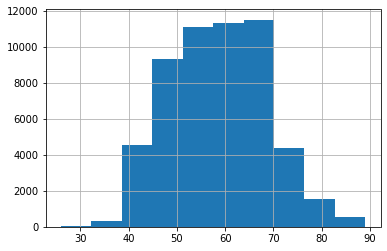

In [ ]:
train_csv.age.hist()

The average age is centered around 60, but given that many women get a mamograph around that age and not earlier we don't know if this data is relevant of biased, but it may be an dinteresting data to include.

In [ ]:
train_csv.laterality.value_counts()

R    27439
L    27267
Name: laterality, dtype: int64

We have about the same amount of left view and right view.

#Dataset preparation

##Undersampling

In [ ]:
#Creating subsets for each outcome
train_subset_0 = train_csv[train_csv.cancer == 0]
train_subset_1 = train_csv[train_csv.cancer == 1]

print(train_subset_0.shape, train_subset_1.shape)
print(train_subset_0.laterality.value_counts())
print(train_subset_1.laterality.value_counts())

(53548, 14) (1158, 14)
R    26869
L    26679
Name: laterality, dtype: int64
L    588
R    570
Name: laterality, dtype: int64


In [ ]:
#Undersampling the training dataset by creating a subset (no rendomization)
train_subset_0_L = train_subset_0[train_subset_0.laterality == "L"].iloc[:588,]
train_subset_0_R = train_subset_0[train_subset_0.laterality == "R"].iloc[:570,]
train_subset_main = pd.concat([train_subset_0_L, train_subset_0_R, train_subset_1])

In [ ]:
train_subset_main

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False


In [ ]:
train_subset_main.laterality.value_counts()

L    1176
R    1140
Name: laterality, dtype: int64

In [ ]:
train_subset_main.shape

(2316, 14)

##Saving new dataset


In [ ]:
os.mkdir('/kaggle/working/input_transformed/')

In [ ]:
os.mkdir('/kaggle/working/input_transformed/0/')
os.mkdir('/kaggle/working/input_transformed/1/')

In [ ]:
import shutil
from tqdm import tqdm
# shutil.copyfile(src, dst)

In [ ]:
from PIL import Image
patientid = train_subset_main.patient_id
imageid = train_subset_main.image_id
hascancer = train_subset_main.cancer
for patient_id, image_id, has_cancer in tqdm(zip(patientid, imageid, hascancer)):
    tmpFile = str(patient_id) + "_" + str(image_id) + ".png"
    tmpSrc = "/kaggle/input/rsna-breast-cancer-512-pngs/" + tmpFile
    tmpDst = "/kaggle/working/input_transformed/" + str(has_cancer) + "/" + tmpFile
    shutil.copyfile(tmpSrc, tmpDst)
    #Loading destination file
    img = Image.open(tmpDst)
    #Resizing the image to be 255x255 to fit in VGG19, using antialiasing
    img = img.resize((255,255), Image.ANTIALIAS)
    #Saving to destination file
    img.save(tmpDst)

2316it [00:41, 56.03it/s]


##Loading the dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/input_transformed/",
    color_mode='rgb',
    image_size=(255, 255),
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42,
)

Found 2316 files belonging to 2 classes.
Using 1853 files for training.


2023-01-12 13:41:37.587298: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-12 13:41:37.593186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-12 13:41:37.709370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 13:41:37.710137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2023-01-12 13:41:37.710298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-1

In [ ]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/input_transformed/",
    color_mode='rgb',
    image_size=(255, 255),
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=2023,
)

Found 2316 files belonging to 2 classes.
Using 463 files for validation.


#Model Training

Importing and crating the model

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
num_classes = 2

#importing VGG19 and loading it into another model
model = VGG19(weights="imagenet", include_top=False, input_shape=(255, 255, 3))
new_model = Sequential()
new_model.add(model)

#Adding layer on top for adaptation
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(2, activation='softmax'))




80142336/80134624 [==============================] - 0s 0us/step


##Assessing ressources

In [ ]:
#Showing number of GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
#Optimization of memory space
gc.collect()

1395

##Defining hyperparameters

In [ ]:
#Adding hyperparameters and metrics
#Categorical Entropy helps when testing to show independence
new_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        'acc',
        tf.keras.metrics.categorical_accuracy,
    ]
)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.995:#Check for overfitting
            print("\nReached 99.5% accuracy so cancelling training!") 
            # Stop training once the above condition is met
            self.model.stop_training = True

##Training the model

In [ ]:
epochs=1
history = new_model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
)

2023-01-12 13:41:43.947371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-12 13:41:43.961520: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000210000 Hz
2023-01-12 13:41:44.231290: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-12 13:41:46.252986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-01-12 13:41:46.310476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


58/58 [==============================] - 74s 872ms/step - loss: 19.1662 - acc: 0.4991 - categorical_accuracy: 0.4836 - val_loss: 0.6979 - val_acc: 0.4600 - val_categorical_accuracy: 0.9654


#Displaying Results

In [ ]:
#Gathering Validation And training Accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

#Gathering Loss and validation loss data
loss = history.history['loss']
val_loss = history.history['val_loss']

#Gathering 
cat_acc = history.history['categorical_accuracy']
cat_val_acc = history.history['val_categorical_accuracy']

#Gathering the X value
epochs_range = range(epochs)


plt.figure(figsize=(20, 10))

#Displaying Accurraccy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Displaying Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

#Diplaying the first batch of results
plt.show()

#Creating new figures
plt.figure(figsize=(10, 10))

#Displaying Categorical accuracy
plt.plot(epochs_range, cat_acc, label='Training Categorical accuracy')
plt.plot(epochs_range, cat_val_acc, label='Validation Categorical accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Categorical accuracy')

#Diplaying the final batch of results
plt.show()


#Model usage

##Loading data

In [ ]:
import numpy as np
from PIL import Image
from skimage import transform
from pprint import pprint

In [ ]:
def load(filename):
   """Load and transform and image from a filename, returns an array of size (255,255,3)"""
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (255, 255, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

##Starting predictions

In [ ]:
testdata_path = "/kaggle/input/rsna-screen-breast-cancer-detect-testdata-512x512"
pred_dict = dict()
for image_id in os.listdir(testdata_path):
    tmpPath = testdata_path + "/" + image_id
    image = load(tmpPath)
    predictions = new_model.predict(image)
    score = tf.nn.softmax(predictions[0])
    pred_dict[image_id] = float(max(score))

In [ ]:
#Creating a result sample
testD = {"10008_L":{"736471439.png":0, "1591370361.png":0}, 
         "10008_R":{"68070693.png":0,"361203119.png":0}}

#Filling the sample
for k1 in testD:
    for k2 in testD[k1]:
        testD[k1][k2] = pred_dict[k2]

#Pretty priting the results
pprint(testD)

{'10008_L': {'1591370361.png': 0.515083909034729,
             '736471439.png': 0.5135526061058044},
 '10008_R': {'361203119.png': 0.5051926374435425,
             '68070693.png': 0.5077361464500427}}


##Formatting submission file

We're going to read the submission file in order to understand how do they want it to be displayed.

In [ ]:
submission = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv")
submission

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


Since we only have 1 result, we will average the results of our predictions for each side of the mammograph

In [ ]:
for iterator in range(submission.shape[0]):
    tmpKey = submission.prediction_id.iloc[iterator]
    submission.cancer.iloc[iterator] = np.mean(list(testD[tmpKey].values()))#Averaging result between images

We can now submit our results.

In [ ]:
submission.to_csv("submission.csv")
submission